# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

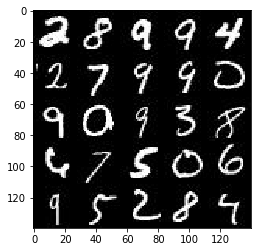

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

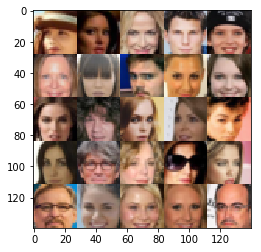

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Define Custom Activation Function

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    tmp1 = scale * tf.nn.elu(x)
    tmp2 = scale * alpha * (tf.nn.elu(-1*tf.nn.relu(-1*x)))
    return tmp1 + tmp2

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # assume that images have shape 28x28x?
        
        layer1 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same')
        layer1_act = selu(layer1)
        # 14x14
        
        layer1x = tf.layers.conv2d(layer1_act, 128, 1, strides=1, padding='valid')
        layer1x_act = selu(layer1x)
        # 14x14
        
        layer2 = tf.layers.conv2d(layer1x_act, 256, 5, strides=2, padding='same')
        layer2_act = selu(layer2)
        layer2_drop = tf.nn.dropout(layer2_act, keep_prob=0.7)
        # 7x7
        
        layer2x = tf.layers.conv2d_transpose(layer2_drop, 128, 1, strides=1, padding='valid')
        layer2x_act = selu(layer2x)
        # 7x7
        
        layer2_rs = tf.reshape(layer2x_act, (-1, 7*7*128))
        
        logits = tf.layers.dense(layer2_rs, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1_rs = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1_act = selu(layer1_rs)
        # 7x7

        layer2 = tf.layers.conv2d_transpose(layer1_act, 256, 5, strides=2, padding='same')
        layer2_act = selu(layer2)
        # 14x14
        layer2x = tf.layers.conv2d_transpose(layer2_act, 256, 1, strides=1, padding='valid')
        layer2x_act = selu(layer2x)
        # 14x14
        res_layer2 = layer2_act + layer2x_act
                
        logits = tf.layers.conv2d_transpose(res_layer2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x?

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_ = tf.trainable_variables()
    g_vars = [var for var in vars_ if var.name.startswith('generator')]
    d_vars = [var for var in vars_ if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5)):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                    
    
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Step 10 Discriminator Loss: 0.6885... Generator Loss: 1.8937
Epoch 1/5... Step 20 Discriminator Loss: 0.4517... Generator Loss: 9.2679
Epoch 1/5... Step 30 Discriminator Loss: 0.3589... Generator Loss: 6.9708
Epoch 1/5... Step 40 Discriminator Loss: 0.3882... Generator Loss: 6.1547
Epoch 1/5... Step 50 Discriminator Loss: 2.0803... Generator Loss: 4.5472
Epoch 1/5... Step 60 Discriminator Loss: 1.4895... Generator Loss: 3.9481
Epoch 1/5... Step 70 Discriminator Loss: 2.4796... Generator Loss: 0.5320
Epoch 1/5... Step 80 Discriminator Loss: 1.4605... Generator Loss: 1.8414
Epoch 1/5... Step 90 Discriminator Loss: 1.0259... Generator Loss: 1.3129
Epoch 1/5... Step 100 Discriminator Loss: 0.9513... Generator Loss: 1.6317


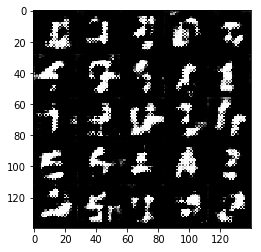

Epoch 1/5... Step 110 Discriminator Loss: 1.1792... Generator Loss: 1.6860
Epoch 1/5... Step 120 Discriminator Loss: 1.1099... Generator Loss: 1.5602
Epoch 1/5... Step 130 Discriminator Loss: 1.2175... Generator Loss: 1.1580
Epoch 1/5... Step 140 Discriminator Loss: 1.0587... Generator Loss: 1.2740
Epoch 1/5... Step 150 Discriminator Loss: 1.1397... Generator Loss: 1.5210
Epoch 1/5... Step 160 Discriminator Loss: 1.3988... Generator Loss: 0.5877
Epoch 1/5... Step 170 Discriminator Loss: 1.8736... Generator Loss: 0.3485
Epoch 1/5... Step 180 Discriminator Loss: 1.2615... Generator Loss: 0.8984
Epoch 1/5... Step 190 Discriminator Loss: 1.4468... Generator Loss: 0.6893
Epoch 1/5... Step 200 Discriminator Loss: 1.3113... Generator Loss: 1.4345


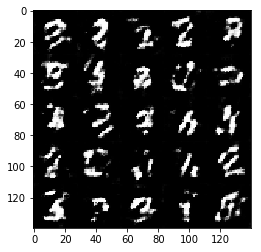

Epoch 1/5... Step 210 Discriminator Loss: 1.3406... Generator Loss: 0.8259
Epoch 1/5... Step 220 Discriminator Loss: 1.3607... Generator Loss: 1.0146
Epoch 1/5... Step 230 Discriminator Loss: 1.5391... Generator Loss: 0.8615
Epoch 1/5... Step 240 Discriminator Loss: 1.7494... Generator Loss: 0.9813
Epoch 1/5... Step 250 Discriminator Loss: 1.7898... Generator Loss: 0.5583
Epoch 1/5... Step 260 Discriminator Loss: 1.5350... Generator Loss: 1.1176
Epoch 1/5... Step 270 Discriminator Loss: 1.2690... Generator Loss: 1.0433
Epoch 1/5... Step 280 Discriminator Loss: 1.3127... Generator Loss: 1.4675
Epoch 1/5... Step 290 Discriminator Loss: 1.2093... Generator Loss: 0.8744
Epoch 1/5... Step 300 Discriminator Loss: 1.2527... Generator Loss: 1.5054


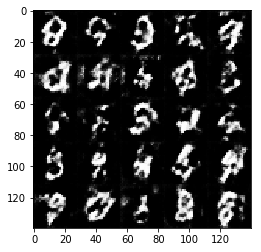

Epoch 1/5... Step 310 Discriminator Loss: 1.2529... Generator Loss: 1.0806
Epoch 1/5... Step 320 Discriminator Loss: 1.3320... Generator Loss: 0.6802
Epoch 1/5... Step 330 Discriminator Loss: 1.1955... Generator Loss: 0.7281
Epoch 1/5... Step 340 Discriminator Loss: 1.2071... Generator Loss: 1.2132
Epoch 1/5... Step 350 Discriminator Loss: 1.1421... Generator Loss: 1.2079
Epoch 1/5... Step 360 Discriminator Loss: 1.2162... Generator Loss: 1.6532
Epoch 1/5... Step 370 Discriminator Loss: 1.2306... Generator Loss: 1.0039
Epoch 1/5... Step 380 Discriminator Loss: 1.2509... Generator Loss: 0.6149
Epoch 1/5... Step 390 Discriminator Loss: 1.1323... Generator Loss: 1.4001
Epoch 1/5... Step 400 Discriminator Loss: 1.1732... Generator Loss: 0.7160


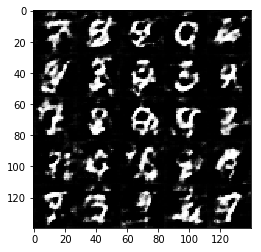

Epoch 1/5... Step 410 Discriminator Loss: 1.1441... Generator Loss: 1.2547
Epoch 1/5... Step 420 Discriminator Loss: 1.2036... Generator Loss: 1.7341
Epoch 1/5... Step 430 Discriminator Loss: 1.0670... Generator Loss: 1.0374
Epoch 1/5... Step 440 Discriminator Loss: 1.1539... Generator Loss: 1.0936
Epoch 1/5... Step 450 Discriminator Loss: 1.1320... Generator Loss: 1.0457
Epoch 1/5... Step 460 Discriminator Loss: 1.1969... Generator Loss: 0.8267
Epoch 1/5... Step 470 Discriminator Loss: 1.1471... Generator Loss: 1.4848
Epoch 1/5... Step 480 Discriminator Loss: 1.1407... Generator Loss: 0.9170
Epoch 1/5... Step 490 Discriminator Loss: 1.2487... Generator Loss: 0.6463
Epoch 1/5... Step 500 Discriminator Loss: 1.2582... Generator Loss: 0.7849


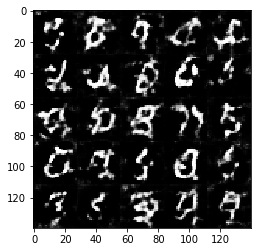

Epoch 1/5... Step 510 Discriminator Loss: 1.1759... Generator Loss: 0.7361
Epoch 1/5... Step 520 Discriminator Loss: 1.0594... Generator Loss: 1.4037
Epoch 1/5... Step 530 Discriminator Loss: 1.0926... Generator Loss: 1.0290
Epoch 1/5... Step 540 Discriminator Loss: 1.4104... Generator Loss: 1.6073
Epoch 1/5... Step 550 Discriminator Loss: 1.1375... Generator Loss: 1.0325
Epoch 1/5... Step 560 Discriminator Loss: 1.2446... Generator Loss: 0.8426
Epoch 1/5... Step 570 Discriminator Loss: 1.4212... Generator Loss: 1.9183
Epoch 1/5... Step 580 Discriminator Loss: 1.1647... Generator Loss: 1.1067
Epoch 1/5... Step 590 Discriminator Loss: 1.3700... Generator Loss: 0.5546
Epoch 1/5... Step 600 Discriminator Loss: 1.2431... Generator Loss: 0.8775


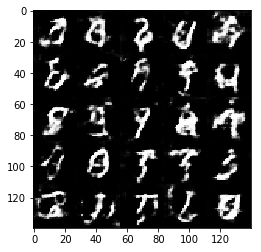

Epoch 1/5... Step 610 Discriminator Loss: 1.1186... Generator Loss: 0.8427
Epoch 1/5... Step 620 Discriminator Loss: 1.1763... Generator Loss: 1.1052
Epoch 1/5... Step 630 Discriminator Loss: 1.3438... Generator Loss: 0.7909
Epoch 1/5... Step 640 Discriminator Loss: 1.2580... Generator Loss: 0.8835
Epoch 1/5... Step 650 Discriminator Loss: 1.2615... Generator Loss: 1.1945
Epoch 1/5... Step 660 Discriminator Loss: 1.2823... Generator Loss: 1.1329
Epoch 1/5... Step 670 Discriminator Loss: 0.9748... Generator Loss: 1.8265
Epoch 1/5... Step 680 Discriminator Loss: 1.2163... Generator Loss: 1.0038
Epoch 1/5... Step 690 Discriminator Loss: 1.3507... Generator Loss: 0.6292
Epoch 1/5... Step 700 Discriminator Loss: 1.2460... Generator Loss: 0.8068


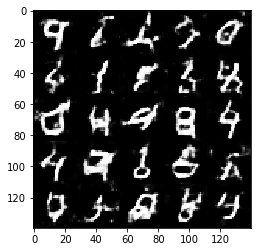

Epoch 1/5... Step 710 Discriminator Loss: 1.3846... Generator Loss: 0.5831
Epoch 1/5... Step 720 Discriminator Loss: 1.1985... Generator Loss: 0.9621
Epoch 1/5... Step 730 Discriminator Loss: 1.2833... Generator Loss: 1.1370
Epoch 1/5... Step 740 Discriminator Loss: 1.2432... Generator Loss: 0.8396
Epoch 1/5... Step 750 Discriminator Loss: 1.2053... Generator Loss: 0.8591
Epoch 1/5... Step 760 Discriminator Loss: 1.1256... Generator Loss: 1.1285
Epoch 1/5... Step 770 Discriminator Loss: 1.5400... Generator Loss: 1.8092
Epoch 1/5... Step 780 Discriminator Loss: 1.1971... Generator Loss: 1.0782
Epoch 1/5... Step 790 Discriminator Loss: 1.3024... Generator Loss: 1.1130
Epoch 1/5... Step 800 Discriminator Loss: 1.2357... Generator Loss: 0.9290


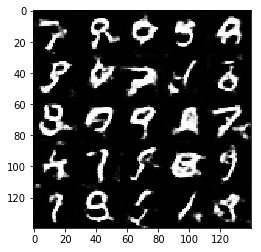

Epoch 1/5... Step 810 Discriminator Loss: 1.3090... Generator Loss: 0.7251
Epoch 1/5... Step 820 Discriminator Loss: 1.2028... Generator Loss: 1.1598
Epoch 1/5... Step 830 Discriminator Loss: 1.3523... Generator Loss: 1.6350
Epoch 1/5... Step 840 Discriminator Loss: 1.2467... Generator Loss: 0.9963
Epoch 1/5... Step 850 Discriminator Loss: 1.2194... Generator Loss: 0.8781
Epoch 1/5... Step 860 Discriminator Loss: 1.9539... Generator Loss: 2.0405
Epoch 1/5... Step 870 Discriminator Loss: 1.2719... Generator Loss: 0.7215
Epoch 1/5... Step 880 Discriminator Loss: 1.2736... Generator Loss: 0.9860
Epoch 1/5... Step 890 Discriminator Loss: 1.2513... Generator Loss: 0.9222
Epoch 1/5... Step 900 Discriminator Loss: 1.1635... Generator Loss: 1.0010


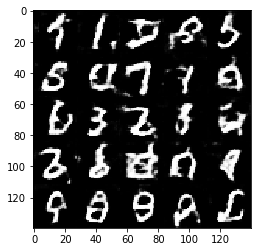

Epoch 1/5... Step 910 Discriminator Loss: 1.1811... Generator Loss: 1.0412
Epoch 1/5... Step 920 Discriminator Loss: 1.3013... Generator Loss: 0.9530
Epoch 1/5... Step 930 Discriminator Loss: 1.2221... Generator Loss: 0.8782
Epoch 2/5... Step 940 Discriminator Loss: 1.2176... Generator Loss: 0.8618
Epoch 2/5... Step 950 Discriminator Loss: 1.2728... Generator Loss: 0.7694
Epoch 2/5... Step 960 Discriminator Loss: 1.2074... Generator Loss: 1.0369
Epoch 2/5... Step 970 Discriminator Loss: 1.3429... Generator Loss: 0.6735
Epoch 2/5... Step 980 Discriminator Loss: 1.4947... Generator Loss: 0.4970
Epoch 2/5... Step 990 Discriminator Loss: 1.3199... Generator Loss: 1.7110
Epoch 2/5... Step 1000 Discriminator Loss: 1.2223... Generator Loss: 0.7670


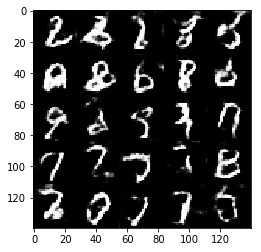

Epoch 2/5... Step 1010 Discriminator Loss: 1.2904... Generator Loss: 0.9192
Epoch 2/5... Step 1020 Discriminator Loss: 1.1658... Generator Loss: 0.9849
Epoch 2/5... Step 1030 Discriminator Loss: 1.2888... Generator Loss: 0.9701
Epoch 2/5... Step 1040 Discriminator Loss: 1.1959... Generator Loss: 0.9500
Epoch 2/5... Step 1050 Discriminator Loss: 1.2598... Generator Loss: 0.6887
Epoch 2/5... Step 1060 Discriminator Loss: 1.2005... Generator Loss: 0.8282
Epoch 2/5... Step 1070 Discriminator Loss: 1.3633... Generator Loss: 0.7062
Epoch 2/5... Step 1080 Discriminator Loss: 1.2811... Generator Loss: 1.2169
Epoch 2/5... Step 1090 Discriminator Loss: 1.1316... Generator Loss: 1.0554
Epoch 2/5... Step 1100 Discriminator Loss: 1.3801... Generator Loss: 0.8550


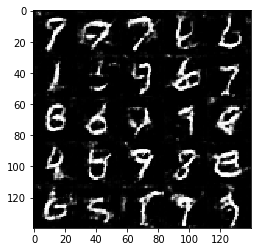

Epoch 2/5... Step 1110 Discriminator Loss: 1.1001... Generator Loss: 1.0139
Epoch 2/5... Step 1120 Discriminator Loss: 1.1737... Generator Loss: 0.7995
Epoch 2/5... Step 1130 Discriminator Loss: 1.1980... Generator Loss: 0.8569
Epoch 2/5... Step 1140 Discriminator Loss: 1.2618... Generator Loss: 0.8013
Epoch 2/5... Step 1150 Discriminator Loss: 1.1863... Generator Loss: 1.3942
Epoch 2/5... Step 1160 Discriminator Loss: 1.2379... Generator Loss: 1.0753
Epoch 2/5... Step 1170 Discriminator Loss: 1.1953... Generator Loss: 1.4931
Epoch 2/5... Step 1180 Discriminator Loss: 1.3931... Generator Loss: 1.0277
Epoch 2/5... Step 1190 Discriminator Loss: 1.0465... Generator Loss: 1.3012
Epoch 2/5... Step 1200 Discriminator Loss: 1.1917... Generator Loss: 1.1846


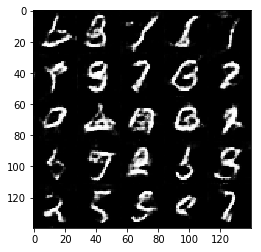

Epoch 2/5... Step 1210 Discriminator Loss: 1.0701... Generator Loss: 1.2580
Epoch 2/5... Step 1220 Discriminator Loss: 1.1900... Generator Loss: 1.0740
Epoch 2/5... Step 1230 Discriminator Loss: 1.1710... Generator Loss: 1.1058
Epoch 2/5... Step 1240 Discriminator Loss: 1.3509... Generator Loss: 0.6599
Epoch 2/5... Step 1250 Discriminator Loss: 1.3478... Generator Loss: 0.7339
Epoch 2/5... Step 1260 Discriminator Loss: 1.2602... Generator Loss: 1.0456
Epoch 2/5... Step 1270 Discriminator Loss: 1.1384... Generator Loss: 1.9111
Epoch 2/5... Step 1280 Discriminator Loss: 1.2931... Generator Loss: 1.2191
Epoch 2/5... Step 1290 Discriminator Loss: 1.2462... Generator Loss: 1.4485
Epoch 2/5... Step 1300 Discriminator Loss: 1.1878... Generator Loss: 1.1417


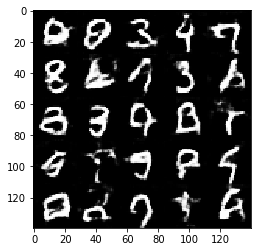

Epoch 2/5... Step 1310 Discriminator Loss: 1.3371... Generator Loss: 0.7958
Epoch 2/5... Step 1320 Discriminator Loss: 67.7043... Generator Loss: 0.0000
Epoch 2/5... Step 1330 Discriminator Loss: 12.2519... Generator Loss: 15.3330
Epoch 2/5... Step 1340 Discriminator Loss: 2.9374... Generator Loss: 0.4543
Epoch 2/5... Step 1350 Discriminator Loss: 2.5822... Generator Loss: 0.4107
Epoch 2/5... Step 1360 Discriminator Loss: 4.2759... Generator Loss: 5.6659
Epoch 2/5... Step 1370 Discriminator Loss: 2.7292... Generator Loss: 4.5447
Epoch 2/5... Step 1380 Discriminator Loss: 2.0308... Generator Loss: 3.8392
Epoch 2/5... Step 1390 Discriminator Loss: 2.5793... Generator Loss: 3.2313
Epoch 2/5... Step 1400 Discriminator Loss: 3.7443... Generator Loss: 5.0376


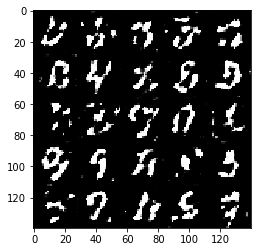

Epoch 2/5... Step 1410 Discriminator Loss: 1.7450... Generator Loss: 0.6981
Epoch 2/5... Step 1420 Discriminator Loss: 2.0606... Generator Loss: 0.5242
Epoch 2/5... Step 1430 Discriminator Loss: 1.4451... Generator Loss: 0.6154
Epoch 2/5... Step 1440 Discriminator Loss: 1.5056... Generator Loss: 0.9405
Epoch 2/5... Step 1450 Discriminator Loss: 1.7660... Generator Loss: 0.6570
Epoch 2/5... Step 1460 Discriminator Loss: 1.7062... Generator Loss: 0.9133
Epoch 2/5... Step 1470 Discriminator Loss: 1.6691... Generator Loss: 2.9391
Epoch 2/5... Step 1480 Discriminator Loss: 1.4316... Generator Loss: 0.5672
Epoch 2/5... Step 1490 Discriminator Loss: 2.1936... Generator Loss: 0.2622
Epoch 2/5... Step 1500 Discriminator Loss: 2.1975... Generator Loss: 0.3145


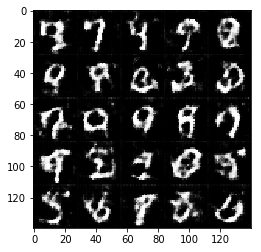

Epoch 2/5... Step 1510 Discriminator Loss: 1.6220... Generator Loss: 0.6910
Epoch 2/5... Step 1520 Discriminator Loss: 1.5415... Generator Loss: 0.6878
Epoch 2/5... Step 1530 Discriminator Loss: 1.8514... Generator Loss: 1.6177
Epoch 2/5... Step 1540 Discriminator Loss: 1.5488... Generator Loss: 1.4273
Epoch 2/5... Step 1550 Discriminator Loss: 1.5156... Generator Loss: 1.1661
Epoch 2/5... Step 1560 Discriminator Loss: 1.2440... Generator Loss: 0.9870
Epoch 2/5... Step 1570 Discriminator Loss: 1.8135... Generator Loss: 1.0140
Epoch 2/5... Step 1580 Discriminator Loss: 1.3667... Generator Loss: 1.5330
Epoch 2/5... Step 1590 Discriminator Loss: 1.5356... Generator Loss: 1.9594
Epoch 2/5... Step 1600 Discriminator Loss: 1.3590... Generator Loss: 1.0824


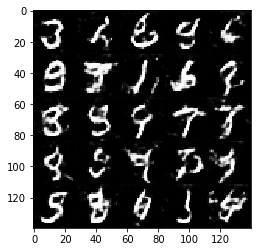

Epoch 2/5... Step 1610 Discriminator Loss: 1.7259... Generator Loss: 2.3054
Epoch 2/5... Step 1620 Discriminator Loss: 1.4101... Generator Loss: 0.8371
Epoch 2/5... Step 1630 Discriminator Loss: 1.4296... Generator Loss: 0.6393
Epoch 2/5... Step 1640 Discriminator Loss: 1.3102... Generator Loss: 0.7056
Epoch 2/5... Step 1650 Discriminator Loss: 1.4356... Generator Loss: 1.1973
Epoch 2/5... Step 1660 Discriminator Loss: 1.5865... Generator Loss: 0.5632
Epoch 2/5... Step 1670 Discriminator Loss: 1.3231... Generator Loss: 0.6503
Epoch 2/5... Step 1680 Discriminator Loss: 1.4056... Generator Loss: 1.1104
Epoch 2/5... Step 1690 Discriminator Loss: 1.3756... Generator Loss: 1.1561
Epoch 2/5... Step 1700 Discriminator Loss: 1.2465... Generator Loss: 1.0081


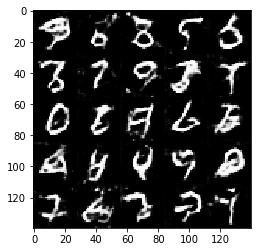

Epoch 2/5... Step 1710 Discriminator Loss: 1.1556... Generator Loss: 1.2322
Epoch 2/5... Step 1720 Discriminator Loss: 1.3824... Generator Loss: 1.2031
Epoch 2/5... Step 1730 Discriminator Loss: 1.4168... Generator Loss: 0.5719
Epoch 2/5... Step 1740 Discriminator Loss: 1.8523... Generator Loss: 1.5775
Epoch 2/5... Step 1750 Discriminator Loss: 1.3495... Generator Loss: 0.7587
Epoch 2/5... Step 1760 Discriminator Loss: 1.3864... Generator Loss: 0.7062
Epoch 2/5... Step 1770 Discriminator Loss: 1.3695... Generator Loss: 1.3005
Epoch 2/5... Step 1780 Discriminator Loss: 1.3100... Generator Loss: 1.0241
Epoch 2/5... Step 1790 Discriminator Loss: 1.6255... Generator Loss: 1.6406
Epoch 2/5... Step 1800 Discriminator Loss: 1.3080... Generator Loss: 0.7856


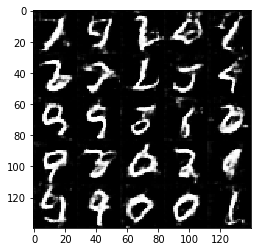

Epoch 2/5... Step 1810 Discriminator Loss: 1.2603... Generator Loss: 1.1604
Epoch 2/5... Step 1820 Discriminator Loss: 1.5065... Generator Loss: 0.5643
Epoch 2/5... Step 1830 Discriminator Loss: 1.2634... Generator Loss: 0.8983
Epoch 2/5... Step 1840 Discriminator Loss: 1.2184... Generator Loss: 0.7877
Epoch 2/5... Step 1850 Discriminator Loss: 1.2822... Generator Loss: 0.7802
Epoch 2/5... Step 1860 Discriminator Loss: 1.2184... Generator Loss: 0.7321
Epoch 2/5... Step 1870 Discriminator Loss: 1.2040... Generator Loss: 1.1688
Epoch 3/5... Step 1880 Discriminator Loss: 1.6747... Generator Loss: 0.4208
Epoch 3/5... Step 1890 Discriminator Loss: 1.2941... Generator Loss: 0.7973
Epoch 3/5... Step 1900 Discriminator Loss: 1.2046... Generator Loss: 0.8539


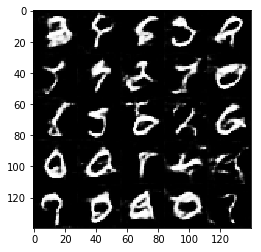

Epoch 3/5... Step 1910 Discriminator Loss: 1.3059... Generator Loss: 0.8058
Epoch 3/5... Step 1920 Discriminator Loss: 1.2348... Generator Loss: 0.8093
Epoch 3/5... Step 1930 Discriminator Loss: 1.2698... Generator Loss: 0.9963
Epoch 3/5... Step 1940 Discriminator Loss: 1.1188... Generator Loss: 1.3064
Epoch 3/5... Step 1950 Discriminator Loss: 1.1855... Generator Loss: 0.9862
Epoch 3/5... Step 1960 Discriminator Loss: 1.2856... Generator Loss: 0.8765
Epoch 3/5... Step 1970 Discriminator Loss: 1.1576... Generator Loss: 1.1692
Epoch 3/5... Step 1980 Discriminator Loss: 1.3253... Generator Loss: 0.8755
Epoch 3/5... Step 1990 Discriminator Loss: 1.3472... Generator Loss: 0.7737
Epoch 3/5... Step 2000 Discriminator Loss: 1.3133... Generator Loss: 0.7317


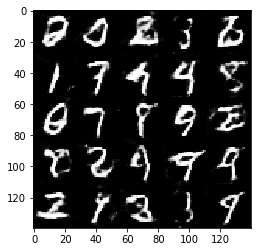

Epoch 3/5... Step 2010 Discriminator Loss: 1.4194... Generator Loss: 0.6909
Epoch 3/5... Step 2020 Discriminator Loss: 1.2182... Generator Loss: 0.8373
Epoch 3/5... Step 2030 Discriminator Loss: 1.2704... Generator Loss: 0.8760
Epoch 3/5... Step 2040 Discriminator Loss: 1.2876... Generator Loss: 0.6626
Epoch 3/5... Step 2050 Discriminator Loss: 1.2844... Generator Loss: 0.9589
Epoch 3/5... Step 2060 Discriminator Loss: 1.2120... Generator Loss: 1.0129
Epoch 3/5... Step 2070 Discriminator Loss: 1.2546... Generator Loss: 1.1939
Epoch 3/5... Step 2080 Discriminator Loss: 1.1984... Generator Loss: 1.1702
Epoch 3/5... Step 2090 Discriminator Loss: 1.1804... Generator Loss: 0.9058
Epoch 3/5... Step 2100 Discriminator Loss: 1.2300... Generator Loss: 0.8175


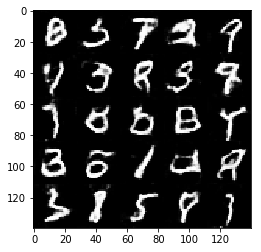

Epoch 3/5... Step 2110 Discriminator Loss: 1.2144... Generator Loss: 0.7622
Epoch 3/5... Step 2120 Discriminator Loss: 1.2759... Generator Loss: 0.9103
Epoch 3/5... Step 2130 Discriminator Loss: 1.3017... Generator Loss: 1.2428
Epoch 3/5... Step 2140 Discriminator Loss: 1.3304... Generator Loss: 0.6641
Epoch 3/5... Step 2150 Discriminator Loss: 1.3639... Generator Loss: 0.8927
Epoch 3/5... Step 2160 Discriminator Loss: 1.3201... Generator Loss: 1.1814
Epoch 3/5... Step 2170 Discriminator Loss: 1.2728... Generator Loss: 0.7620
Epoch 3/5... Step 2180 Discriminator Loss: 1.2813... Generator Loss: 0.9569
Epoch 3/5... Step 2190 Discriminator Loss: 1.0572... Generator Loss: 1.3241
Epoch 3/5... Step 2200 Discriminator Loss: 1.2451... Generator Loss: 1.8196


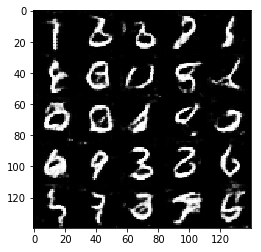

Epoch 3/5... Step 2210 Discriminator Loss: 1.1633... Generator Loss: 1.1891
Epoch 3/5... Step 2220 Discriminator Loss: 1.3657... Generator Loss: 1.0247
Epoch 3/5... Step 2230 Discriminator Loss: 1.2716... Generator Loss: 1.0357
Epoch 3/5... Step 2240 Discriminator Loss: 1.4431... Generator Loss: 0.6063
Epoch 3/5... Step 2250 Discriminator Loss: 1.3356... Generator Loss: 0.6649
Epoch 3/5... Step 2260 Discriminator Loss: 1.1105... Generator Loss: 1.1190
Epoch 3/5... Step 2270 Discriminator Loss: 1.3386... Generator Loss: 0.7082
Epoch 3/5... Step 2280 Discriminator Loss: 1.3336... Generator Loss: 0.9025
Epoch 3/5... Step 2290 Discriminator Loss: 1.2317... Generator Loss: 1.3584
Epoch 3/5... Step 2300 Discriminator Loss: 1.2552... Generator Loss: 0.7103


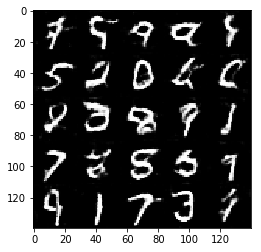

Epoch 3/5... Step 2310 Discriminator Loss: 1.1525... Generator Loss: 1.1742
Epoch 3/5... Step 2320 Discriminator Loss: 1.2390... Generator Loss: 1.3833
Epoch 3/5... Step 2330 Discriminator Loss: 1.2431... Generator Loss: 0.8041
Epoch 3/5... Step 2340 Discriminator Loss: 1.2971... Generator Loss: 0.9858
Epoch 3/5... Step 2350 Discriminator Loss: 1.0940... Generator Loss: 1.3811
Epoch 3/5... Step 2360 Discriminator Loss: 3.1458... Generator Loss: 2.9290
Epoch 3/5... Step 2370 Discriminator Loss: 2.6113... Generator Loss: 0.8658
Epoch 3/5... Step 2380 Discriminator Loss: 1.9802... Generator Loss: 0.2877
Epoch 3/5... Step 2390 Discriminator Loss: 1.9182... Generator Loss: 0.2982
Epoch 3/5... Step 2400 Discriminator Loss: 1.3852... Generator Loss: 0.8952


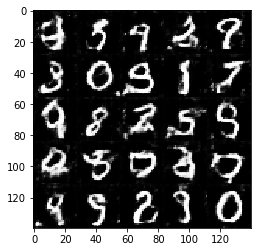

Epoch 3/5... Step 2410 Discriminator Loss: 1.4895... Generator Loss: 1.5960
Epoch 3/5... Step 2420 Discriminator Loss: 1.2377... Generator Loss: 1.2774
Epoch 3/5... Step 2430 Discriminator Loss: 1.2785... Generator Loss: 1.0811
Epoch 3/5... Step 2440 Discriminator Loss: 1.1817... Generator Loss: 0.9549
Epoch 3/5... Step 2450 Discriminator Loss: 1.2145... Generator Loss: 1.1396
Epoch 3/5... Step 2460 Discriminator Loss: 1.1691... Generator Loss: 0.9880
Epoch 3/5... Step 2470 Discriminator Loss: 1.3741... Generator Loss: 0.5603
Epoch 3/5... Step 2480 Discriminator Loss: 1.1456... Generator Loss: 0.9680
Epoch 3/5... Step 2490 Discriminator Loss: 1.2137... Generator Loss: 0.8561
Epoch 3/5... Step 2500 Discriminator Loss: 1.2014... Generator Loss: 0.9486


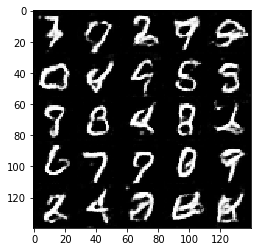

Epoch 3/5... Step 2510 Discriminator Loss: 1.1740... Generator Loss: 0.9104
Epoch 3/5... Step 2520 Discriminator Loss: 1.1605... Generator Loss: 1.0864
Epoch 3/5... Step 2530 Discriminator Loss: 1.1919... Generator Loss: 0.7335
Epoch 3/5... Step 2540 Discriminator Loss: 1.2937... Generator Loss: 0.9063
Epoch 3/5... Step 2550 Discriminator Loss: 1.0853... Generator Loss: 1.1762
Epoch 3/5... Step 2560 Discriminator Loss: 1.1812... Generator Loss: 1.3937
Epoch 3/5... Step 2570 Discriminator Loss: 1.1378... Generator Loss: 0.9184
Epoch 3/5... Step 2580 Discriminator Loss: 1.1460... Generator Loss: 1.2250
Epoch 3/5... Step 2590 Discriminator Loss: 1.1834... Generator Loss: 0.9249
Epoch 3/5... Step 2600 Discriminator Loss: 1.2175... Generator Loss: 0.8985


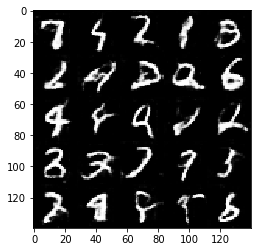

Epoch 3/5... Step 2610 Discriminator Loss: 1.2095... Generator Loss: 0.8998
Epoch 3/5... Step 2620 Discriminator Loss: 1.3436... Generator Loss: 0.6413
Epoch 3/5... Step 2630 Discriminator Loss: 1.2692... Generator Loss: 0.7383
Epoch 3/5... Step 2640 Discriminator Loss: 1.2585... Generator Loss: 0.7515
Epoch 3/5... Step 2650 Discriminator Loss: 1.1678... Generator Loss: 1.2346
Epoch 3/5... Step 2660 Discriminator Loss: 1.2846... Generator Loss: 0.8429
Epoch 3/5... Step 2670 Discriminator Loss: 1.2207... Generator Loss: 0.9250
Epoch 3/5... Step 2680 Discriminator Loss: 1.2504... Generator Loss: 0.9660
Epoch 3/5... Step 2690 Discriminator Loss: 1.2580... Generator Loss: 1.5260
Epoch 3/5... Step 2700 Discriminator Loss: 1.2523... Generator Loss: 0.9210


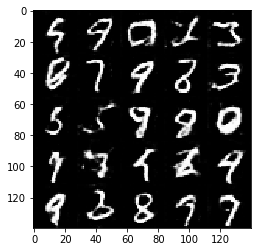

Epoch 3/5... Step 2710 Discriminator Loss: 1.1791... Generator Loss: 1.6112
Epoch 3/5... Step 2720 Discriminator Loss: 1.1249... Generator Loss: 0.9993
Epoch 3/5... Step 2730 Discriminator Loss: 1.3133... Generator Loss: 0.7758
Epoch 3/5... Step 2740 Discriminator Loss: 1.1586... Generator Loss: 1.0425
Epoch 3/5... Step 2750 Discriminator Loss: 1.1771... Generator Loss: 1.0385
Epoch 3/5... Step 2760 Discriminator Loss: 1.2305... Generator Loss: 1.3859
Epoch 3/5... Step 2770 Discriminator Loss: 1.1830... Generator Loss: 1.2305
Epoch 3/5... Step 2780 Discriminator Loss: 1.1644... Generator Loss: 1.1619
Epoch 3/5... Step 2790 Discriminator Loss: 1.1491... Generator Loss: 1.2336
Epoch 3/5... Step 2800 Discriminator Loss: 1.2573... Generator Loss: 1.4136


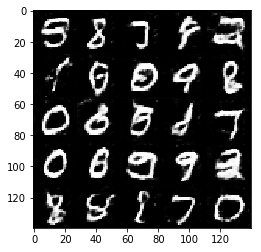

Epoch 3/5... Step 2810 Discriminator Loss: 1.2077... Generator Loss: 0.9749
Epoch 4/5... Step 2820 Discriminator Loss: 1.0836... Generator Loss: 1.4785
Epoch 4/5... Step 2830 Discriminator Loss: 1.1945... Generator Loss: 1.2329
Epoch 4/5... Step 2840 Discriminator Loss: 1.1588... Generator Loss: 0.9704
Epoch 4/5... Step 2850 Discriminator Loss: 0.9423... Generator Loss: 1.1534
Epoch 4/5... Step 2860 Discriminator Loss: 1.1187... Generator Loss: 0.8145
Epoch 4/5... Step 2870 Discriminator Loss: 1.1425... Generator Loss: 1.3955
Epoch 4/5... Step 2880 Discriminator Loss: 1.2286... Generator Loss: 0.9716
Epoch 4/5... Step 2890 Discriminator Loss: 1.1562... Generator Loss: 1.3932
Epoch 4/5... Step 2900 Discriminator Loss: 1.0402... Generator Loss: 1.2124


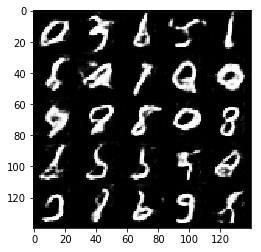

Epoch 4/5... Step 2910 Discriminator Loss: 3.3956... Generator Loss: 4.2093
Epoch 4/5... Step 2920 Discriminator Loss: 3.3445... Generator Loss: 3.5980
Epoch 4/5... Step 2930 Discriminator Loss: 2.2522... Generator Loss: 1.7688
Epoch 4/5... Step 2940 Discriminator Loss: 1.4786... Generator Loss: 1.5601
Epoch 4/5... Step 2950 Discriminator Loss: 1.2768... Generator Loss: 1.1033
Epoch 4/5... Step 2960 Discriminator Loss: 1.3216... Generator Loss: 0.7904
Epoch 4/5... Step 2970 Discriminator Loss: 1.2168... Generator Loss: 0.9427
Epoch 4/5... Step 2980 Discriminator Loss: 1.1926... Generator Loss: 1.0146
Epoch 4/5... Step 2990 Discriminator Loss: 1.2860... Generator Loss: 0.7717
Epoch 4/5... Step 3000 Discriminator Loss: 1.2520... Generator Loss: 0.7641


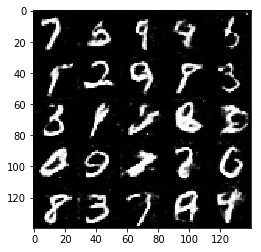

Epoch 4/5... Step 3010 Discriminator Loss: 1.2318... Generator Loss: 1.1199
Epoch 4/5... Step 3020 Discriminator Loss: 1.2348... Generator Loss: 0.9454
Epoch 4/5... Step 3030 Discriminator Loss: 1.0915... Generator Loss: 0.9044
Epoch 4/5... Step 3040 Discriminator Loss: 1.1500... Generator Loss: 0.9653
Epoch 4/5... Step 3050 Discriminator Loss: 1.0641... Generator Loss: 1.1160
Epoch 4/5... Step 3060 Discriminator Loss: 1.1860... Generator Loss: 1.2238
Epoch 4/5... Step 3070 Discriminator Loss: 1.2036... Generator Loss: 1.1866
Epoch 4/5... Step 3080 Discriminator Loss: 1.0845... Generator Loss: 1.4967
Epoch 4/5... Step 3090 Discriminator Loss: 1.0600... Generator Loss: 1.0625
Epoch 4/5... Step 3100 Discriminator Loss: 1.1657... Generator Loss: 0.8517


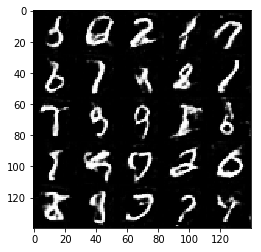

Epoch 4/5... Step 3110 Discriminator Loss: 1.2153... Generator Loss: 0.8627
Epoch 4/5... Step 3120 Discriminator Loss: 1.1579... Generator Loss: 0.8965
Epoch 4/5... Step 3130 Discriminator Loss: 1.2040... Generator Loss: 0.8461
Epoch 4/5... Step 3140 Discriminator Loss: 1.2097... Generator Loss: 0.8190
Epoch 4/5... Step 3150 Discriminator Loss: 1.1527... Generator Loss: 0.9516
Epoch 4/5... Step 3160 Discriminator Loss: 1.3377... Generator Loss: 0.6065
Epoch 4/5... Step 3170 Discriminator Loss: 1.2684... Generator Loss: 0.8216
Epoch 4/5... Step 3180 Discriminator Loss: 1.1364... Generator Loss: 1.2560
Epoch 4/5... Step 3190 Discriminator Loss: 1.1987... Generator Loss: 0.8441
Epoch 4/5... Step 3200 Discriminator Loss: 1.3640... Generator Loss: 0.5881


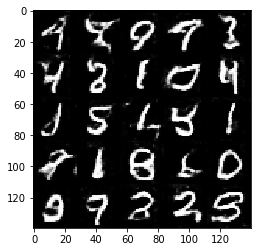

Epoch 4/5... Step 3210 Discriminator Loss: 1.3108... Generator Loss: 0.7694
Epoch 4/5... Step 3220 Discriminator Loss: 1.0716... Generator Loss: 1.3648
Epoch 4/5... Step 3230 Discriminator Loss: 1.1870... Generator Loss: 0.7778
Epoch 4/5... Step 3240 Discriminator Loss: 1.1431... Generator Loss: 1.1464
Epoch 4/5... Step 3250 Discriminator Loss: 1.2005... Generator Loss: 0.9783
Epoch 4/5... Step 3260 Discriminator Loss: 1.1252... Generator Loss: 1.1075
Epoch 4/5... Step 3270 Discriminator Loss: 1.1119... Generator Loss: 1.0565
Epoch 4/5... Step 3280 Discriminator Loss: 1.2198... Generator Loss: 1.3842
Epoch 4/5... Step 3290 Discriminator Loss: 1.0393... Generator Loss: 1.3606
Epoch 4/5... Step 3300 Discriminator Loss: 1.0087... Generator Loss: 1.1445


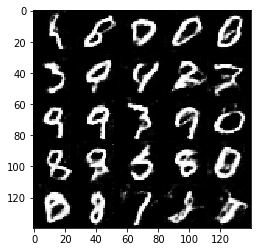

Epoch 4/5... Step 3310 Discriminator Loss: 1.2192... Generator Loss: 1.0152
Epoch 4/5... Step 3320 Discriminator Loss: 1.2023... Generator Loss: 1.2452
Epoch 4/5... Step 3330 Discriminator Loss: 1.1241... Generator Loss: 1.5210
Epoch 4/5... Step 3340 Discriminator Loss: 1.1803... Generator Loss: 0.9299
Epoch 4/5... Step 3350 Discriminator Loss: 1.2376... Generator Loss: 0.9943
Epoch 4/5... Step 3360 Discriminator Loss: 1.2127... Generator Loss: 0.9070
Epoch 4/5... Step 3370 Discriminator Loss: 1.1983... Generator Loss: 0.8300
Epoch 4/5... Step 3380 Discriminator Loss: 1.1282... Generator Loss: 1.2296
Epoch 4/5... Step 3390 Discriminator Loss: 1.3139... Generator Loss: 0.6314
Epoch 4/5... Step 3400 Discriminator Loss: 1.1226... Generator Loss: 1.0448


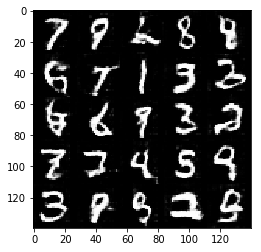

Epoch 4/5... Step 3410 Discriminator Loss: 1.0674... Generator Loss: 1.4008
Epoch 4/5... Step 3420 Discriminator Loss: 1.4842... Generator Loss: 2.5607
Epoch 4/5... Step 3430 Discriminator Loss: 1.1906... Generator Loss: 0.9340
Epoch 4/5... Step 3440 Discriminator Loss: 1.2065... Generator Loss: 1.0168
Epoch 4/5... Step 3450 Discriminator Loss: 1.2809... Generator Loss: 0.8497
Epoch 4/5... Step 3460 Discriminator Loss: 1.2452... Generator Loss: 0.8128
Epoch 4/5... Step 3470 Discriminator Loss: 1.1775... Generator Loss: 0.9377
Epoch 4/5... Step 3480 Discriminator Loss: 1.1769... Generator Loss: 0.8377
Epoch 4/5... Step 3490 Discriminator Loss: 1.1488... Generator Loss: 1.2293
Epoch 4/5... Step 3500 Discriminator Loss: 1.2097... Generator Loss: 0.9618


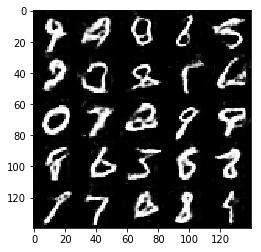

Epoch 4/5... Step 3510 Discriminator Loss: 1.2366... Generator Loss: 1.6452
Epoch 4/5... Step 3520 Discriminator Loss: 1.0846... Generator Loss: 1.5876
Epoch 4/5... Step 3530 Discriminator Loss: 1.0010... Generator Loss: 1.8534
Epoch 4/5... Step 3540 Discriminator Loss: 1.1230... Generator Loss: 0.9550
Epoch 4/5... Step 3550 Discriminator Loss: 1.2646... Generator Loss: 2.2519
Epoch 4/5... Step 3560 Discriminator Loss: 1.0940... Generator Loss: 0.9917
Epoch 4/5... Step 3570 Discriminator Loss: 1.0932... Generator Loss: 1.3458
Epoch 4/5... Step 3580 Discriminator Loss: 1.3161... Generator Loss: 0.7119
Epoch 4/5... Step 3590 Discriminator Loss: 1.0957... Generator Loss: 1.3267
Epoch 4/5... Step 3600 Discriminator Loss: 1.2200... Generator Loss: 0.8218


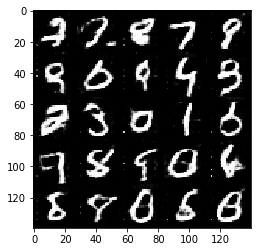

Epoch 4/5... Step 3610 Discriminator Loss: 1.0511... Generator Loss: 1.3241
Epoch 4/5... Step 3620 Discriminator Loss: 1.1900... Generator Loss: 1.4422
Epoch 4/5... Step 3630 Discriminator Loss: 1.1455... Generator Loss: 0.9302
Epoch 4/5... Step 3640 Discriminator Loss: 1.0706... Generator Loss: 1.2765
Epoch 4/5... Step 3650 Discriminator Loss: 1.1041... Generator Loss: 1.3213
Epoch 4/5... Step 3660 Discriminator Loss: 1.0604... Generator Loss: 1.5246
Epoch 4/5... Step 3670 Discriminator Loss: 1.3643... Generator Loss: 0.6765
Epoch 4/5... Step 3680 Discriminator Loss: 1.1692... Generator Loss: 1.0690
Epoch 4/5... Step 3690 Discriminator Loss: 1.0473... Generator Loss: 0.9439
Epoch 4/5... Step 3700 Discriminator Loss: 2.0963... Generator Loss: 0.3477


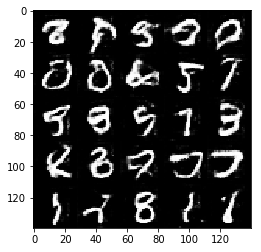

Epoch 4/5... Step 3710 Discriminator Loss: 1.1965... Generator Loss: 1.1582
Epoch 4/5... Step 3720 Discriminator Loss: 1.3083... Generator Loss: 0.7103
Epoch 4/5... Step 3730 Discriminator Loss: 0.9566... Generator Loss: 1.1942
Epoch 4/5... Step 3740 Discriminator Loss: 1.0864... Generator Loss: 1.1963
Epoch 5/5... Step 3750 Discriminator Loss: 1.0681... Generator Loss: 1.1448
Epoch 5/5... Step 3760 Discriminator Loss: 1.2186... Generator Loss: 1.0740
Epoch 5/5... Step 3770 Discriminator Loss: 1.1120... Generator Loss: 0.9319
Epoch 5/5... Step 3780 Discriminator Loss: 1.0973... Generator Loss: 1.2061
Epoch 5/5... Step 3790 Discriminator Loss: 1.1290... Generator Loss: 0.9828
Epoch 5/5... Step 3800 Discriminator Loss: 1.0782... Generator Loss: 1.0221


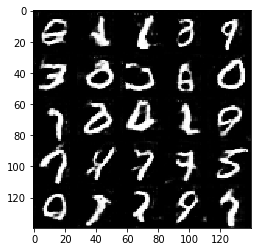

Epoch 5/5... Step 3810 Discriminator Loss: 1.2660... Generator Loss: 0.8300
Epoch 5/5... Step 3820 Discriminator Loss: 1.1562... Generator Loss: 1.1651
Epoch 5/5... Step 3830 Discriminator Loss: 1.2487... Generator Loss: 1.4924
Epoch 5/5... Step 3840 Discriminator Loss: 1.3163... Generator Loss: 0.7689
Epoch 5/5... Step 3850 Discriminator Loss: 1.3061... Generator Loss: 0.7292
Epoch 5/5... Step 3860 Discriminator Loss: 1.1343... Generator Loss: 1.1649
Epoch 5/5... Step 3870 Discriminator Loss: 1.1154... Generator Loss: 1.3203
Epoch 5/5... Step 3880 Discriminator Loss: 0.9702... Generator Loss: 1.4486
Epoch 5/5... Step 3890 Discriminator Loss: 1.0603... Generator Loss: 1.6040
Epoch 5/5... Step 3900 Discriminator Loss: 1.0245... Generator Loss: 1.4363


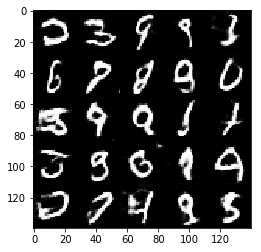

Epoch 5/5... Step 3910 Discriminator Loss: 1.0358... Generator Loss: 1.0290
Epoch 5/5... Step 3920 Discriminator Loss: 1.1900... Generator Loss: 0.9748
Epoch 5/5... Step 3930 Discriminator Loss: 0.9400... Generator Loss: 1.4345
Epoch 5/5... Step 3940 Discriminator Loss: 1.2753... Generator Loss: 0.8031
Epoch 5/5... Step 3950 Discriminator Loss: 1.0826... Generator Loss: 0.9617
Epoch 5/5... Step 3960 Discriminator Loss: 1.1257... Generator Loss: 0.9560
Epoch 5/5... Step 3970 Discriminator Loss: 1.0991... Generator Loss: 1.3749
Epoch 5/5... Step 3980 Discriminator Loss: 1.2004... Generator Loss: 0.9084
Epoch 5/5... Step 3990 Discriminator Loss: 1.1947... Generator Loss: 0.8523
Epoch 5/5... Step 4000 Discriminator Loss: 1.1137... Generator Loss: 1.5769


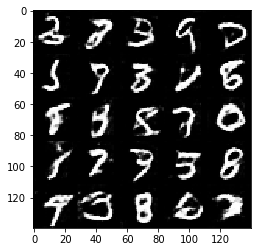

Epoch 5/5... Step 4010 Discriminator Loss: 1.0934... Generator Loss: 1.1001
Epoch 5/5... Step 4020 Discriminator Loss: 1.2399... Generator Loss: 0.7150
Epoch 5/5... Step 4030 Discriminator Loss: 0.9695... Generator Loss: 1.3181
Epoch 5/5... Step 4040 Discriminator Loss: 1.1360... Generator Loss: 1.1793
Epoch 5/5... Step 4050 Discriminator Loss: 1.0560... Generator Loss: 1.4568
Epoch 5/5... Step 4060 Discriminator Loss: 1.1504... Generator Loss: 1.1362
Epoch 5/5... Step 4070 Discriminator Loss: 1.3617... Generator Loss: 0.6167
Epoch 5/5... Step 4080 Discriminator Loss: 1.1376... Generator Loss: 0.9695
Epoch 5/5... Step 4090 Discriminator Loss: 1.1219... Generator Loss: 1.1287
Epoch 5/5... Step 4100 Discriminator Loss: 1.1327... Generator Loss: 1.1710


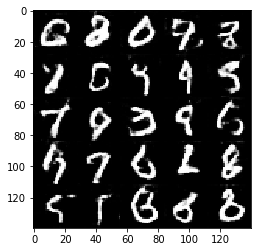

Epoch 5/5... Step 4110 Discriminator Loss: 1.2709... Generator Loss: 0.7154
Epoch 5/5... Step 4120 Discriminator Loss: 1.1515... Generator Loss: 1.1430
Epoch 5/5... Step 4130 Discriminator Loss: 0.8638... Generator Loss: 1.4476
Epoch 5/5... Step 4140 Discriminator Loss: 1.0529... Generator Loss: 1.3846
Epoch 5/5... Step 4150 Discriminator Loss: 1.1363... Generator Loss: 2.2679
Epoch 5/5... Step 4160 Discriminator Loss: 1.0893... Generator Loss: 1.0371
Epoch 5/5... Step 4170 Discriminator Loss: 1.1917... Generator Loss: 0.9564
Epoch 5/5... Step 4180 Discriminator Loss: 1.0496... Generator Loss: 1.2834
Epoch 5/5... Step 4190 Discriminator Loss: 0.9001... Generator Loss: 1.5079
Epoch 5/5... Step 4200 Discriminator Loss: 1.1473... Generator Loss: 0.9176


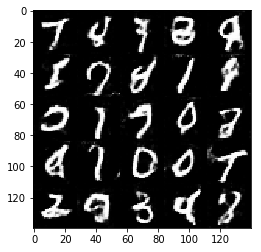

Epoch 5/5... Step 4210 Discriminator Loss: 0.9615... Generator Loss: 1.1799
Epoch 5/5... Step 4220 Discriminator Loss: 1.1883... Generator Loss: 0.8503
Epoch 5/5... Step 4230 Discriminator Loss: 1.0560... Generator Loss: 1.0843
Epoch 5/5... Step 4240 Discriminator Loss: 1.0679... Generator Loss: 1.0801
Epoch 5/5... Step 4250 Discriminator Loss: 1.0140... Generator Loss: 1.6981
Epoch 5/5... Step 4260 Discriminator Loss: 1.1047... Generator Loss: 1.3086
Epoch 5/5... Step 4270 Discriminator Loss: 1.0986... Generator Loss: 1.0431
Epoch 5/5... Step 4280 Discriminator Loss: 1.0425... Generator Loss: 1.1471
Epoch 5/5... Step 4290 Discriminator Loss: 1.2472... Generator Loss: 0.7915
Epoch 5/5... Step 4300 Discriminator Loss: 1.1727... Generator Loss: 0.8939


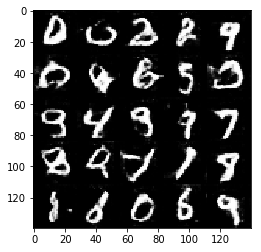

Epoch 5/5... Step 4310 Discriminator Loss: 1.2320... Generator Loss: 0.7650
Epoch 5/5... Step 4320 Discriminator Loss: 1.1289... Generator Loss: 1.0624
Epoch 5/5... Step 4330 Discriminator Loss: 0.9254... Generator Loss: 1.5192
Epoch 5/5... Step 4340 Discriminator Loss: 1.1381... Generator Loss: 2.1419
Epoch 5/5... Step 4350 Discriminator Loss: 0.9805... Generator Loss: 2.5544
Epoch 5/5... Step 4360 Discriminator Loss: 1.2018... Generator Loss: 0.8549
Epoch 5/5... Step 4370 Discriminator Loss: 1.1912... Generator Loss: 0.8673
Epoch 5/5... Step 4380 Discriminator Loss: 1.0198... Generator Loss: 1.0765
Epoch 5/5... Step 4390 Discriminator Loss: 0.9275... Generator Loss: 1.3532
Epoch 5/5... Step 4400 Discriminator Loss: 1.1568... Generator Loss: 1.7836


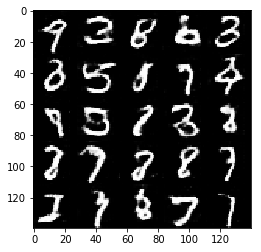

Epoch 5/5... Step 4410 Discriminator Loss: 1.1224... Generator Loss: 0.9606
Epoch 5/5... Step 4420 Discriminator Loss: 1.2558... Generator Loss: 2.4399
Epoch 5/5... Step 4430 Discriminator Loss: 1.0019... Generator Loss: 1.4479
Epoch 5/5... Step 4440 Discriminator Loss: 0.8783... Generator Loss: 1.9378
Epoch 5/5... Step 4450 Discriminator Loss: 0.9580... Generator Loss: 1.4439
Epoch 5/5... Step 4460 Discriminator Loss: 1.5230... Generator Loss: 0.5345
Epoch 5/5... Step 4470 Discriminator Loss: 7.0110... Generator Loss: 0.0373
Epoch 5/5... Step 4480 Discriminator Loss: 7.3064... Generator Loss: 0.0083
Epoch 5/5... Step 4490 Discriminator Loss: 2.1444... Generator Loss: 1.7652
Epoch 5/5... Step 4500 Discriminator Loss: 6.4708... Generator Loss: 6.6684


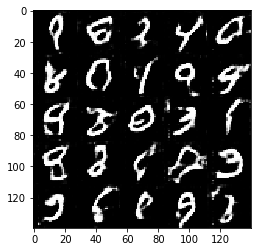

Epoch 5/5... Step 4510 Discriminator Loss: 1.8273... Generator Loss: 1.6865
Epoch 5/5... Step 4520 Discriminator Loss: 1.6815... Generator Loss: 1.0923
Epoch 5/5... Step 4530 Discriminator Loss: 1.9761... Generator Loss: 0.4600
Epoch 5/5... Step 4540 Discriminator Loss: 2.1004... Generator Loss: 0.3593
Epoch 5/5... Step 4550 Discriminator Loss: 1.3278... Generator Loss: 0.9281
Epoch 5/5... Step 4560 Discriminator Loss: 1.2256... Generator Loss: 0.9593
Epoch 5/5... Step 4570 Discriminator Loss: 1.2079... Generator Loss: 0.8688
Epoch 5/5... Step 4580 Discriminator Loss: 1.1824... Generator Loss: 0.7373
Epoch 5/5... Step 4590 Discriminator Loss: 1.1975... Generator Loss: 1.0287
Epoch 5/5... Step 4600 Discriminator Loss: 1.2229... Generator Loss: 0.9726


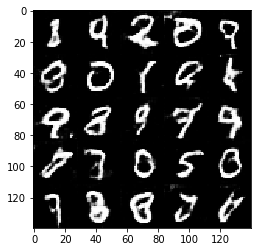

Epoch 5/5... Step 4610 Discriminator Loss: 1.1113... Generator Loss: 1.0422
Epoch 5/5... Step 4620 Discriminator Loss: 1.1582... Generator Loss: 0.8786
Epoch 5/5... Step 4630 Discriminator Loss: 0.9425... Generator Loss: 1.4701
Epoch 5/5... Step 4640 Discriminator Loss: 1.0737... Generator Loss: 1.1346
Epoch 5/5... Step 4650 Discriminator Loss: 0.9949... Generator Loss: 1.5583
Epoch 5/5... Step 4660 Discriminator Loss: 1.0275... Generator Loss: 1.2418
Epoch 5/5... Step 4670 Discriminator Loss: 1.0463... Generator Loss: 1.0815
Epoch 5/5... Step 4680 Discriminator Loss: 1.0884... Generator Loss: 1.0228


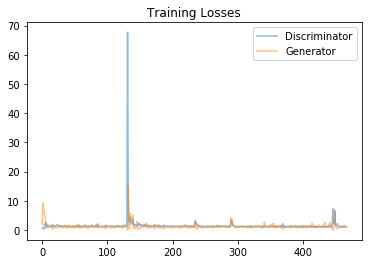

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 Discriminator Loss: 0.6012... Generator Loss: 7.6783
Epoch 1/1... Step 20 Discriminator Loss: 0.8399... Generator Loss: 20.5283
Epoch 1/1... Step 30 Discriminator Loss: 0.9422... Generator Loss: 4.8684
Epoch 1/1... Step 40 Discriminator Loss: 0.6526... Generator Loss: 3.1303
Epoch 1/1... Step 50 Discriminator Loss: 1.4164... Generator Loss: 2.5670
Epoch 1/1... Step 60 Discriminator Loss: 1.8443... Generator Loss: 0.8541
Epoch 1/1... Step 70 Discriminator Loss: 1.2586... Generator Loss: 1.7800
Epoch 1/1... Step 80 Discriminator Loss: 1.5730... Generator Loss: 0.9236
Epoch 1/1... Step 90 Discriminator Loss: 3.3482... Generator Loss: 0.2374
Epoch 1/1... Step 100 Discriminator Loss: 1.6265... Generator Loss: 1.4038


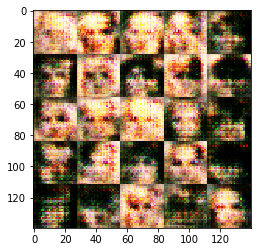

Epoch 1/1... Step 110 Discriminator Loss: 1.9080... Generator Loss: 1.2105
Epoch 1/1... Step 120 Discriminator Loss: 2.5663... Generator Loss: 0.5212
Epoch 1/1... Step 130 Discriminator Loss: 2.2185... Generator Loss: 0.5060
Epoch 1/1... Step 140 Discriminator Loss: 2.5771... Generator Loss: 0.3060
Epoch 1/1... Step 150 Discriminator Loss: 2.0301... Generator Loss: 0.4581
Epoch 1/1... Step 160 Discriminator Loss: 1.7177... Generator Loss: 0.7109
Epoch 1/1... Step 170 Discriminator Loss: 1.8313... Generator Loss: 0.5616
Epoch 1/1... Step 180 Discriminator Loss: 1.5862... Generator Loss: 0.6553
Epoch 1/1... Step 190 Discriminator Loss: 1.6015... Generator Loss: 0.6366
Epoch 1/1... Step 200 Discriminator Loss: 1.5877... Generator Loss: 0.6797


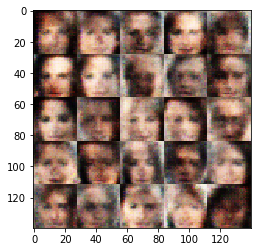

Epoch 1/1... Step 210 Discriminator Loss: 1.7120... Generator Loss: 0.9201
Epoch 1/1... Step 220 Discriminator Loss: 1.4311... Generator Loss: 0.7488
Epoch 1/1... Step 230 Discriminator Loss: 1.9014... Generator Loss: 0.3110
Epoch 1/1... Step 240 Discriminator Loss: 1.6377... Generator Loss: 0.5468
Epoch 1/1... Step 250 Discriminator Loss: 1.5638... Generator Loss: 0.6770
Epoch 1/1... Step 260 Discriminator Loss: 1.6061... Generator Loss: 0.6796
Epoch 1/1... Step 270 Discriminator Loss: 1.4626... Generator Loss: 0.5855
Epoch 1/1... Step 280 Discriminator Loss: 1.6135... Generator Loss: 0.5099
Epoch 1/1... Step 290 Discriminator Loss: 1.5710... Generator Loss: 0.7948
Epoch 1/1... Step 300 Discriminator Loss: 1.7392... Generator Loss: 0.8612


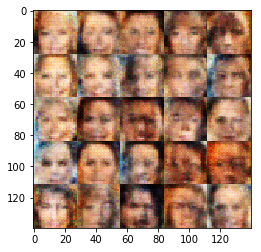

Epoch 1/1... Step 310 Discriminator Loss: 1.5250... Generator Loss: 0.7596
Epoch 1/1... Step 320 Discriminator Loss: 1.6782... Generator Loss: 0.4656
Epoch 1/1... Step 330 Discriminator Loss: 1.4799... Generator Loss: 0.6775
Epoch 1/1... Step 340 Discriminator Loss: 1.4037... Generator Loss: 0.9197
Epoch 1/1... Step 350 Discriminator Loss: 1.6709... Generator Loss: 0.9803
Epoch 1/1... Step 360 Discriminator Loss: 1.4036... Generator Loss: 0.8671
Epoch 1/1... Step 370 Discriminator Loss: 1.2732... Generator Loss: 0.8419
Epoch 1/1... Step 380 Discriminator Loss: 1.3678... Generator Loss: 0.7271
Epoch 1/1... Step 390 Discriminator Loss: 1.4304... Generator Loss: 0.8263
Epoch 1/1... Step 400 Discriminator Loss: 1.4288... Generator Loss: 0.7847


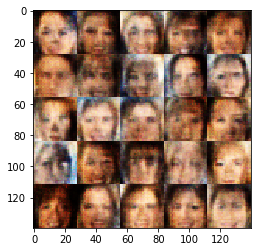

Epoch 1/1... Step 410 Discriminator Loss: 1.4158... Generator Loss: 0.8150
Epoch 1/1... Step 420 Discriminator Loss: 1.5357... Generator Loss: 0.6279
Epoch 1/1... Step 430 Discriminator Loss: 1.6672... Generator Loss: 1.1054
Epoch 1/1... Step 440 Discriminator Loss: 1.4160... Generator Loss: 0.7773
Epoch 1/1... Step 450 Discriminator Loss: 1.5388... Generator Loss: 0.8305
Epoch 1/1... Step 460 Discriminator Loss: 1.4709... Generator Loss: 0.7615
Epoch 1/1... Step 470 Discriminator Loss: 1.4477... Generator Loss: 1.2987
Epoch 1/1... Step 480 Discriminator Loss: 1.4789... Generator Loss: 0.7019
Epoch 1/1... Step 490 Discriminator Loss: 1.3716... Generator Loss: 0.8574
Epoch 1/1... Step 500 Discriminator Loss: 1.4545... Generator Loss: 0.7351


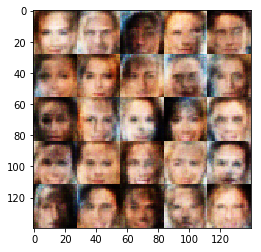

Epoch 1/1... Step 510 Discriminator Loss: 1.4720... Generator Loss: 0.6655
Epoch 1/1... Step 520 Discriminator Loss: 1.4465... Generator Loss: 0.6329
Epoch 1/1... Step 530 Discriminator Loss: 1.4425... Generator Loss: 0.7443
Epoch 1/1... Step 540 Discriminator Loss: 1.4072... Generator Loss: 0.7126
Epoch 1/1... Step 550 Discriminator Loss: 1.3017... Generator Loss: 0.8538
Epoch 1/1... Step 560 Discriminator Loss: 1.3462... Generator Loss: 0.7324
Epoch 1/1... Step 570 Discriminator Loss: 1.4108... Generator Loss: 0.7076
Epoch 1/1... Step 580 Discriminator Loss: 1.3476... Generator Loss: 0.6709
Epoch 1/1... Step 590 Discriminator Loss: 1.4425... Generator Loss: 0.9685
Epoch 1/1... Step 600 Discriminator Loss: 1.4315... Generator Loss: 0.6503


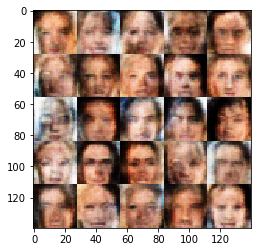

Epoch 1/1... Step 610 Discriminator Loss: 1.4446... Generator Loss: 0.6973
Epoch 1/1... Step 620 Discriminator Loss: 1.3568... Generator Loss: 0.7060
Epoch 1/1... Step 630 Discriminator Loss: 1.4685... Generator Loss: 1.0098
Epoch 1/1... Step 640 Discriminator Loss: 1.4286... Generator Loss: 1.1151
Epoch 1/1... Step 650 Discriminator Loss: 1.4787... Generator Loss: 0.7992
Epoch 1/1... Step 660 Discriminator Loss: 1.5685... Generator Loss: 0.4578
Epoch 1/1... Step 670 Discriminator Loss: 1.5301... Generator Loss: 1.0530
Epoch 1/1... Step 680 Discriminator Loss: 1.4807... Generator Loss: 0.6507
Epoch 1/1... Step 690 Discriminator Loss: 1.4313... Generator Loss: 0.9885
Epoch 1/1... Step 700 Discriminator Loss: 1.3974... Generator Loss: 0.6668


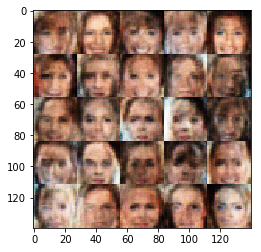

Epoch 1/1... Step 710 Discriminator Loss: 1.4069... Generator Loss: 1.1418
Epoch 1/1... Step 720 Discriminator Loss: 1.3945... Generator Loss: 0.8249
Epoch 1/1... Step 730 Discriminator Loss: 1.5167... Generator Loss: 1.1109
Epoch 1/1... Step 740 Discriminator Loss: 1.4109... Generator Loss: 0.7715
Epoch 1/1... Step 750 Discriminator Loss: 1.3734... Generator Loss: 0.7425
Epoch 1/1... Step 760 Discriminator Loss: 1.4656... Generator Loss: 0.9860
Epoch 1/1... Step 770 Discriminator Loss: 1.3741... Generator Loss: 0.7995
Epoch 1/1... Step 780 Discriminator Loss: 1.4948... Generator Loss: 0.6538
Epoch 1/1... Step 790 Discriminator Loss: 1.4836... Generator Loss: 0.9732
Epoch 1/1... Step 800 Discriminator Loss: 1.5115... Generator Loss: 0.6173


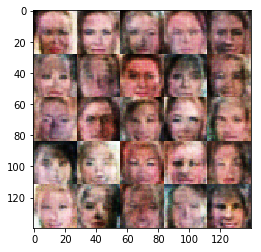

Epoch 1/1... Step 810 Discriminator Loss: 1.4188... Generator Loss: 0.9290
Epoch 1/1... Step 820 Discriminator Loss: 1.4381... Generator Loss: 0.7152
Epoch 1/1... Step 830 Discriminator Loss: 1.4795... Generator Loss: 0.7258
Epoch 1/1... Step 840 Discriminator Loss: 1.4688... Generator Loss: 1.0708
Epoch 1/1... Step 850 Discriminator Loss: 1.3592... Generator Loss: 0.7432
Epoch 1/1... Step 860 Discriminator Loss: 1.4045... Generator Loss: 0.9667
Epoch 1/1... Step 870 Discriminator Loss: 1.3723... Generator Loss: 0.8564
Epoch 1/1... Step 880 Discriminator Loss: 1.4561... Generator Loss: 0.7740
Epoch 1/1... Step 890 Discriminator Loss: 1.3576... Generator Loss: 0.8843
Epoch 1/1... Step 900 Discriminator Loss: 1.4460... Generator Loss: 0.7142


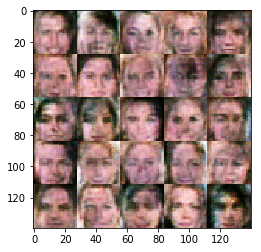

Epoch 1/1... Step 910 Discriminator Loss: 1.6761... Generator Loss: 1.5084
Epoch 1/1... Step 920 Discriminator Loss: 1.5125... Generator Loss: 0.6254
Epoch 1/1... Step 930 Discriminator Loss: 1.5575... Generator Loss: 0.8212
Epoch 1/1... Step 940 Discriminator Loss: 1.3993... Generator Loss: 0.8660
Epoch 1/1... Step 950 Discriminator Loss: 1.3550... Generator Loss: 0.8041
Epoch 1/1... Step 960 Discriminator Loss: 1.4627... Generator Loss: 0.8070
Epoch 1/1... Step 970 Discriminator Loss: 1.4626... Generator Loss: 1.0180
Epoch 1/1... Step 980 Discriminator Loss: 1.3928... Generator Loss: 0.7253
Epoch 1/1... Step 990 Discriminator Loss: 1.4252... Generator Loss: 0.7652
Epoch 1/1... Step 1000 Discriminator Loss: 1.3807... Generator Loss: 0.7101


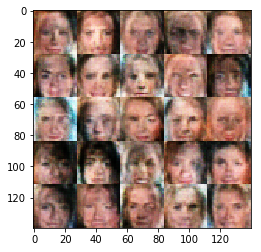

Epoch 1/1... Step 1010 Discriminator Loss: 1.4871... Generator Loss: 0.5689
Epoch 1/1... Step 1020 Discriminator Loss: 1.4209... Generator Loss: 0.7556
Epoch 1/1... Step 1030 Discriminator Loss: 1.3625... Generator Loss: 0.9369
Epoch 1/1... Step 1040 Discriminator Loss: 1.4443... Generator Loss: 0.7423
Epoch 1/1... Step 1050 Discriminator Loss: 1.4509... Generator Loss: 0.8781
Epoch 1/1... Step 1060 Discriminator Loss: 1.3938... Generator Loss: 0.8275
Epoch 1/1... Step 1070 Discriminator Loss: 1.4002... Generator Loss: 0.8883
Epoch 1/1... Step 1080 Discriminator Loss: 1.5152... Generator Loss: 1.0797
Epoch 1/1... Step 1090 Discriminator Loss: 1.4134... Generator Loss: 0.7343
Epoch 1/1... Step 1100 Discriminator Loss: 1.3594... Generator Loss: 0.8591


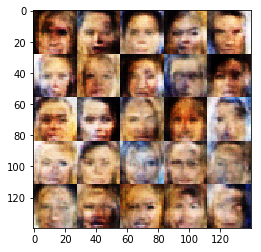

Epoch 1/1... Step 1110 Discriminator Loss: 1.4041... Generator Loss: 0.7731
Epoch 1/1... Step 1120 Discriminator Loss: 1.4387... Generator Loss: 0.7943
Epoch 1/1... Step 1130 Discriminator Loss: 1.5516... Generator Loss: 0.6905
Epoch 1/1... Step 1140 Discriminator Loss: 1.4824... Generator Loss: 0.6827
Epoch 1/1... Step 1150 Discriminator Loss: 1.4552... Generator Loss: 0.6981
Epoch 1/1... Step 1160 Discriminator Loss: 1.4890... Generator Loss: 0.5071
Epoch 1/1... Step 1170 Discriminator Loss: 1.4148... Generator Loss: 0.7038
Epoch 1/1... Step 1180 Discriminator Loss: 1.4965... Generator Loss: 0.6981
Epoch 1/1... Step 1190 Discriminator Loss: 1.5444... Generator Loss: 1.1976
Epoch 1/1... Step 1200 Discriminator Loss: 1.3528... Generator Loss: 0.7896


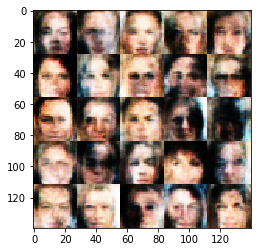

Epoch 1/1... Step 1210 Discriminator Loss: 1.3857... Generator Loss: 0.7448
Epoch 1/1... Step 1220 Discriminator Loss: 2.3880... Generator Loss: 2.3940
Epoch 1/1... Step 1230 Discriminator Loss: 1.4884... Generator Loss: 0.6709
Epoch 1/1... Step 1240 Discriminator Loss: 1.4443... Generator Loss: 0.7295
Epoch 1/1... Step 1250 Discriminator Loss: 1.4622... Generator Loss: 0.5726
Epoch 1/1... Step 1260 Discriminator Loss: 1.4224... Generator Loss: 0.8322
Epoch 1/1... Step 1270 Discriminator Loss: 1.4513... Generator Loss: 0.7711
Epoch 1/1... Step 1280 Discriminator Loss: 1.4024... Generator Loss: 0.7344
Epoch 1/1... Step 1290 Discriminator Loss: 1.4052... Generator Loss: 0.8025
Epoch 1/1... Step 1300 Discriminator Loss: 1.4124... Generator Loss: 0.8406


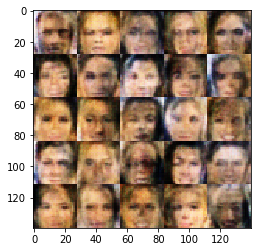

Epoch 1/1... Step 1310 Discriminator Loss: 1.4181... Generator Loss: 0.8561
Epoch 1/1... Step 1320 Discriminator Loss: 1.4629... Generator Loss: 0.7358
Epoch 1/1... Step 1330 Discriminator Loss: 1.4209... Generator Loss: 0.8510
Epoch 1/1... Step 1340 Discriminator Loss: 1.4424... Generator Loss: 0.8529
Epoch 1/1... Step 1350 Discriminator Loss: 1.4237... Generator Loss: 0.7792
Epoch 1/1... Step 1360 Discriminator Loss: 1.4308... Generator Loss: 0.7882
Epoch 1/1... Step 1370 Discriminator Loss: 1.6493... Generator Loss: 0.6355
Epoch 1/1... Step 1380 Discriminator Loss: 1.4742... Generator Loss: 0.6506
Epoch 1/1... Step 1390 Discriminator Loss: 1.3977... Generator Loss: 0.8326
Epoch 1/1... Step 1400 Discriminator Loss: 1.4370... Generator Loss: 0.7275


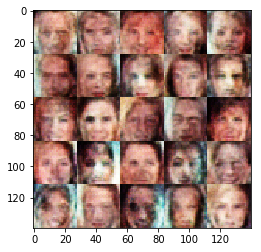

Epoch 1/1... Step 1410 Discriminator Loss: 1.4025... Generator Loss: 0.7535
Epoch 1/1... Step 1420 Discriminator Loss: 1.4349... Generator Loss: 0.8108
Epoch 1/1... Step 1430 Discriminator Loss: 1.4386... Generator Loss: 0.5050
Epoch 1/1... Step 1440 Discriminator Loss: 1.4434... Generator Loss: 0.7516
Epoch 1/1... Step 1450 Discriminator Loss: 1.4524... Generator Loss: 1.1741
Epoch 1/1... Step 1460 Discriminator Loss: 1.3422... Generator Loss: 0.7951
Epoch 1/1... Step 1470 Discriminator Loss: 1.3261... Generator Loss: 0.8349
Epoch 1/1... Step 1480 Discriminator Loss: 1.4301... Generator Loss: 0.7631
Epoch 1/1... Step 1490 Discriminator Loss: 1.4043... Generator Loss: 0.6918
Epoch 1/1... Step 1500 Discriminator Loss: 1.7837... Generator Loss: 1.6116


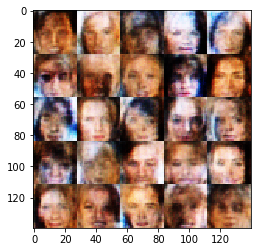

Epoch 1/1... Step 1510 Discriminator Loss: 1.4540... Generator Loss: 0.7013
Epoch 1/1... Step 1520 Discriminator Loss: 1.4229... Generator Loss: 0.7970
Epoch 1/1... Step 1530 Discriminator Loss: 1.5139... Generator Loss: 0.7080
Epoch 1/1... Step 1540 Discriminator Loss: 1.4057... Generator Loss: 0.7473
Epoch 1/1... Step 1550 Discriminator Loss: 1.3208... Generator Loss: 0.8703
Epoch 1/1... Step 1560 Discriminator Loss: 1.4746... Generator Loss: 0.6694
Epoch 1/1... Step 1570 Discriminator Loss: 1.4257... Generator Loss: 0.7254
Epoch 1/1... Step 1580 Discriminator Loss: 1.4044... Generator Loss: 0.8611
Epoch 1/1... Step 1590 Discriminator Loss: 1.4005... Generator Loss: 0.6741
Epoch 1/1... Step 1600 Discriminator Loss: 1.5370... Generator Loss: 0.6819


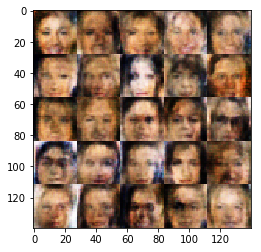

Epoch 1/1... Step 1610 Discriminator Loss: 1.4082... Generator Loss: 0.8480
Epoch 1/1... Step 1620 Discriminator Loss: 1.3939... Generator Loss: 0.8214
Epoch 1/1... Step 1630 Discriminator Loss: 1.5641... Generator Loss: 0.6237
Epoch 1/1... Step 1640 Discriminator Loss: 1.5545... Generator Loss: 0.5657
Epoch 1/1... Step 1650 Discriminator Loss: 1.3215... Generator Loss: 0.8243
Epoch 1/1... Step 1660 Discriminator Loss: 1.4009... Generator Loss: 0.8074
Epoch 1/1... Step 1670 Discriminator Loss: 1.4649... Generator Loss: 0.6879
Epoch 1/1... Step 1680 Discriminator Loss: 1.3302... Generator Loss: 0.7643
Epoch 1/1... Step 1690 Discriminator Loss: 1.5724... Generator Loss: 0.4480
Epoch 1/1... Step 1700 Discriminator Loss: 1.4130... Generator Loss: 0.7840


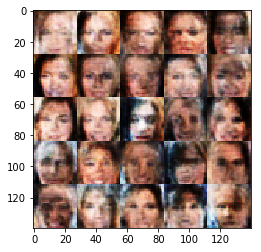

Epoch 1/1... Step 1710 Discriminator Loss: 1.4090... Generator Loss: 0.7971
Epoch 1/1... Step 1720 Discriminator Loss: 1.4465... Generator Loss: 1.0098
Epoch 1/1... Step 1730 Discriminator Loss: 1.3767... Generator Loss: 0.8352
Epoch 1/1... Step 1740 Discriminator Loss: 1.3878... Generator Loss: 0.8481
Epoch 1/1... Step 1750 Discriminator Loss: 1.4892... Generator Loss: 0.5773
Epoch 1/1... Step 1760 Discriminator Loss: 1.4248... Generator Loss: 0.7383
Epoch 1/1... Step 1770 Discriminator Loss: 1.4545... Generator Loss: 0.6634
Epoch 1/1... Step 1780 Discriminator Loss: 1.3406... Generator Loss: 0.8130
Epoch 1/1... Step 1790 Discriminator Loss: 1.4207... Generator Loss: 0.6168
Epoch 1/1... Step 1800 Discriminator Loss: 1.4760... Generator Loss: 1.0710


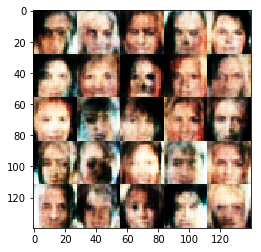

Epoch 1/1... Step 1810 Discriminator Loss: 1.4034... Generator Loss: 0.7672
Epoch 1/1... Step 1820 Discriminator Loss: 1.4064... Generator Loss: 0.6744
Epoch 1/1... Step 1830 Discriminator Loss: 1.4473... Generator Loss: 0.6554
Epoch 1/1... Step 1840 Discriminator Loss: 1.5677... Generator Loss: 0.5814
Epoch 1/1... Step 1850 Discriminator Loss: 1.4779... Generator Loss: 0.5312
Epoch 1/1... Step 1860 Discriminator Loss: 1.5126... Generator Loss: 0.6788
Epoch 1/1... Step 1870 Discriminator Loss: 1.4383... Generator Loss: 0.6925
Epoch 1/1... Step 1880 Discriminator Loss: 1.3496... Generator Loss: 0.7074
Epoch 1/1... Step 1890 Discriminator Loss: 1.4120... Generator Loss: 0.7990
Epoch 1/1... Step 1900 Discriminator Loss: 1.3953... Generator Loss: 0.8239


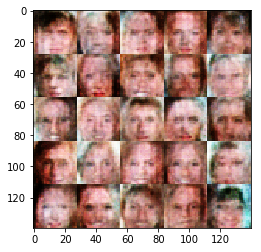

Epoch 1/1... Step 1910 Discriminator Loss: 1.3810... Generator Loss: 0.8497
Epoch 1/1... Step 1920 Discriminator Loss: 1.4076... Generator Loss: 0.8882
Epoch 1/1... Step 1930 Discriminator Loss: 1.4499... Generator Loss: 0.8502
Epoch 1/1... Step 1940 Discriminator Loss: 1.6846... Generator Loss: 1.5026
Epoch 1/1... Step 1950 Discriminator Loss: 1.3724... Generator Loss: 0.8013
Epoch 1/1... Step 1960 Discriminator Loss: 1.3744... Generator Loss: 0.8745
Epoch 1/1... Step 1970 Discriminator Loss: 1.4466... Generator Loss: 0.8185
Epoch 1/1... Step 1980 Discriminator Loss: 1.4214... Generator Loss: 0.9557
Epoch 1/1... Step 1990 Discriminator Loss: 1.3802... Generator Loss: 0.7680
Epoch 1/1... Step 2000 Discriminator Loss: 1.3947... Generator Loss: 0.6512


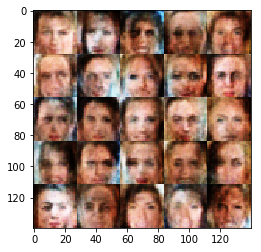

Epoch 1/1... Step 2010 Discriminator Loss: 1.3818... Generator Loss: 0.8087
Epoch 1/1... Step 2020 Discriminator Loss: 1.2387... Generator Loss: 0.8412
Epoch 1/1... Step 2030 Discriminator Loss: 1.3517... Generator Loss: 0.8840
Epoch 1/1... Step 2040 Discriminator Loss: 1.3380... Generator Loss: 0.7452
Epoch 1/1... Step 2050 Discriminator Loss: 1.3230... Generator Loss: 0.7042
Epoch 1/1... Step 2060 Discriminator Loss: 1.4268... Generator Loss: 0.7854
Epoch 1/1... Step 2070 Discriminator Loss: 1.3861... Generator Loss: 0.8660
Epoch 1/1... Step 2080 Discriminator Loss: 1.3511... Generator Loss: 1.0507
Epoch 1/1... Step 2090 Discriminator Loss: 1.3931... Generator Loss: 0.7005
Epoch 1/1... Step 2100 Discriminator Loss: 1.4990... Generator Loss: 0.8405


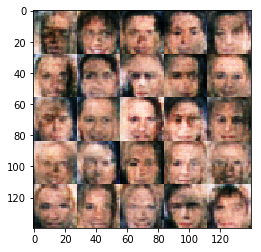

Epoch 1/1... Step 2110 Discriminator Loss: 1.5907... Generator Loss: 1.3219
Epoch 1/1... Step 2120 Discriminator Loss: 1.4133... Generator Loss: 0.7940
Epoch 1/1... Step 2130 Discriminator Loss: 1.4992... Generator Loss: 1.0615
Epoch 1/1... Step 2140 Discriminator Loss: 1.4479... Generator Loss: 0.6803
Epoch 1/1... Step 2150 Discriminator Loss: 1.4066... Generator Loss: 1.0794
Epoch 1/1... Step 2160 Discriminator Loss: 1.4542... Generator Loss: 0.7783
Epoch 1/1... Step 2170 Discriminator Loss: 1.3719... Generator Loss: 0.7293
Epoch 1/1... Step 2180 Discriminator Loss: 1.4627... Generator Loss: 0.7797
Epoch 1/1... Step 2190 Discriminator Loss: 1.3251... Generator Loss: 0.9186
Epoch 1/1... Step 2200 Discriminator Loss: 1.5489... Generator Loss: 0.9573


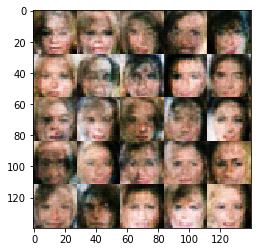

Epoch 1/1... Step 2210 Discriminator Loss: 1.5973... Generator Loss: 0.7035
Epoch 1/1... Step 2220 Discriminator Loss: 1.2959... Generator Loss: 0.9580
Epoch 1/1... Step 2230 Discriminator Loss: 1.7007... Generator Loss: 0.3844
Epoch 1/1... Step 2240 Discriminator Loss: 1.3018... Generator Loss: 0.8117
Epoch 1/1... Step 2250 Discriminator Loss: 1.4766... Generator Loss: 0.8020
Epoch 1/1... Step 2260 Discriminator Loss: 1.3887... Generator Loss: 0.8510
Epoch 1/1... Step 2270 Discriminator Loss: 1.3977... Generator Loss: 0.8420
Epoch 1/1... Step 2280 Discriminator Loss: 1.4134... Generator Loss: 0.8218
Epoch 1/1... Step 2290 Discriminator Loss: 1.3708... Generator Loss: 0.8194
Epoch 1/1... Step 2300 Discriminator Loss: 1.3767... Generator Loss: 0.6855


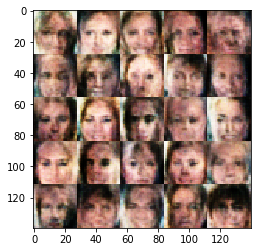

Epoch 1/1... Step 2310 Discriminator Loss: 1.3709... Generator Loss: 0.8563
Epoch 1/1... Step 2320 Discriminator Loss: 1.3455... Generator Loss: 0.9438
Epoch 1/1... Step 2330 Discriminator Loss: 1.4507... Generator Loss: 0.7778
Epoch 1/1... Step 2340 Discriminator Loss: 1.3859... Generator Loss: 0.7054
Epoch 1/1... Step 2350 Discriminator Loss: 1.4459... Generator Loss: 0.6470
Epoch 1/1... Step 2360 Discriminator Loss: 1.3415... Generator Loss: 0.7521
Epoch 1/1... Step 2370 Discriminator Loss: 1.3373... Generator Loss: 0.7705
Epoch 1/1... Step 2380 Discriminator Loss: 1.3583... Generator Loss: 0.7582
Epoch 1/1... Step 2390 Discriminator Loss: 1.4334... Generator Loss: 0.6328
Epoch 1/1... Step 2400 Discriminator Loss: 1.4018... Generator Loss: 0.9030


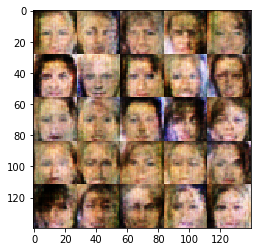

Epoch 1/1... Step 2410 Discriminator Loss: 1.4872... Generator Loss: 0.6096
Epoch 1/1... Step 2420 Discriminator Loss: 1.4870... Generator Loss: 0.4778
Epoch 1/1... Step 2430 Discriminator Loss: 1.3621... Generator Loss: 0.7986
Epoch 1/1... Step 2440 Discriminator Loss: 1.3132... Generator Loss: 0.8779
Epoch 1/1... Step 2450 Discriminator Loss: 1.4330... Generator Loss: 0.7701
Epoch 1/1... Step 2460 Discriminator Loss: 1.3833... Generator Loss: 0.8544
Epoch 1/1... Step 2470 Discriminator Loss: 1.3515... Generator Loss: 0.8197
Epoch 1/1... Step 2480 Discriminator Loss: 1.4819... Generator Loss: 1.3006
Epoch 1/1... Step 2490 Discriminator Loss: 1.4162... Generator Loss: 1.0250
Epoch 1/1... Step 2500 Discriminator Loss: 1.4394... Generator Loss: 0.7799


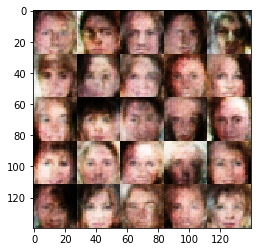

Epoch 1/1... Step 2510 Discriminator Loss: 1.3721... Generator Loss: 0.8893
Epoch 1/1... Step 2520 Discriminator Loss: 1.4280... Generator Loss: 1.0460
Epoch 1/1... Step 2530 Discriminator Loss: 1.3837... Generator Loss: 0.7717
Epoch 1/1... Step 2540 Discriminator Loss: 1.3585... Generator Loss: 0.9558
Epoch 1/1... Step 2550 Discriminator Loss: 1.4501... Generator Loss: 0.8892
Epoch 1/1... Step 2560 Discriminator Loss: 1.3755... Generator Loss: 0.7098
Epoch 1/1... Step 2570 Discriminator Loss: 1.3624... Generator Loss: 0.9761
Epoch 1/1... Step 2580 Discriminator Loss: 1.4054... Generator Loss: 0.7648
Epoch 1/1... Step 2590 Discriminator Loss: 1.4496... Generator Loss: 1.1869
Epoch 1/1... Step 2600 Discriminator Loss: 1.3237... Generator Loss: 0.7411


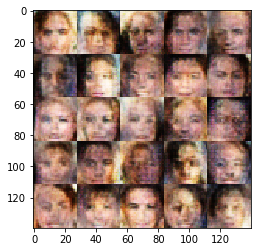

Epoch 1/1... Step 2610 Discriminator Loss: 1.3872... Generator Loss: 0.8675
Epoch 1/1... Step 2620 Discriminator Loss: 1.3937... Generator Loss: 0.7029
Epoch 1/1... Step 2630 Discriminator Loss: 1.3655... Generator Loss: 0.8024
Epoch 1/1... Step 2640 Discriminator Loss: 1.3842... Generator Loss: 0.8784
Epoch 1/1... Step 2650 Discriminator Loss: 1.4227... Generator Loss: 0.6496
Epoch 1/1... Step 2660 Discriminator Loss: 1.3586... Generator Loss: 0.8223
Epoch 1/1... Step 2670 Discriminator Loss: 1.2793... Generator Loss: 0.9837
Epoch 1/1... Step 2680 Discriminator Loss: 1.3815... Generator Loss: 0.8646
Epoch 1/1... Step 2690 Discriminator Loss: 1.3905... Generator Loss: 0.7510
Epoch 1/1... Step 2700 Discriminator Loss: 1.3818... Generator Loss: 0.8607


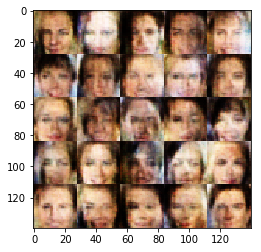

Epoch 1/1... Step 2710 Discriminator Loss: 1.3725... Generator Loss: 0.8366
Epoch 1/1... Step 2720 Discriminator Loss: 1.4045... Generator Loss: 0.7842
Epoch 1/1... Step 2730 Discriminator Loss: 1.5491... Generator Loss: 1.2271
Epoch 1/1... Step 2740 Discriminator Loss: 1.4413... Generator Loss: 0.7936
Epoch 1/1... Step 2750 Discriminator Loss: 1.3952... Generator Loss: 0.7551
Epoch 1/1... Step 2760 Discriminator Loss: 1.4730... Generator Loss: 0.8393
Epoch 1/1... Step 2770 Discriminator Loss: 1.3805... Generator Loss: 0.7950
Epoch 1/1... Step 2780 Discriminator Loss: 1.4304... Generator Loss: 0.7226
Epoch 1/1... Step 2790 Discriminator Loss: 1.4798... Generator Loss: 0.6265
Epoch 1/1... Step 2800 Discriminator Loss: 1.3123... Generator Loss: 0.8099


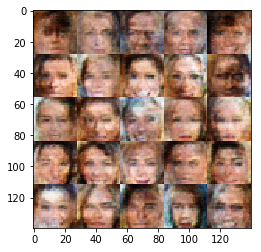

Epoch 1/1... Step 2810 Discriminator Loss: 1.5415... Generator Loss: 0.7429
Epoch 1/1... Step 2820 Discriminator Loss: 1.6132... Generator Loss: 1.0909
Epoch 1/1... Step 2830 Discriminator Loss: 1.5949... Generator Loss: 0.5221
Epoch 1/1... Step 2840 Discriminator Loss: 1.3582... Generator Loss: 0.6971
Epoch 1/1... Step 2850 Discriminator Loss: 1.4829... Generator Loss: 0.8236
Epoch 1/1... Step 2860 Discriminator Loss: 1.3485... Generator Loss: 0.8757
Epoch 1/1... Step 2870 Discriminator Loss: 1.4433... Generator Loss: 0.5325
Epoch 1/1... Step 2880 Discriminator Loss: 1.4284... Generator Loss: 0.7327
Epoch 1/1... Step 2890 Discriminator Loss: 1.3377... Generator Loss: 0.8008
Epoch 1/1... Step 2900 Discriminator Loss: 1.3342... Generator Loss: 0.7562


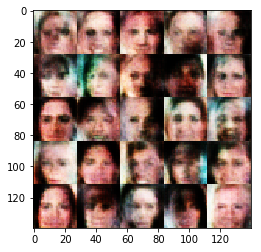

Epoch 1/1... Step 2910 Discriminator Loss: 1.6871... Generator Loss: 1.3787
Epoch 1/1... Step 2920 Discriminator Loss: 1.4347... Generator Loss: 0.9766
Epoch 1/1... Step 2930 Discriminator Loss: 1.4023... Generator Loss: 0.6357
Epoch 1/1... Step 2940 Discriminator Loss: 1.4174... Generator Loss: 0.8062
Epoch 1/1... Step 2950 Discriminator Loss: 1.3358... Generator Loss: 0.7336
Epoch 1/1... Step 2960 Discriminator Loss: 1.3773... Generator Loss: 0.7972
Epoch 1/1... Step 2970 Discriminator Loss: 1.4826... Generator Loss: 0.9209
Epoch 1/1... Step 2980 Discriminator Loss: 1.3334... Generator Loss: 0.8069
Epoch 1/1... Step 2990 Discriminator Loss: 1.3664... Generator Loss: 0.8810
Epoch 1/1... Step 3000 Discriminator Loss: 1.4104... Generator Loss: 0.6517


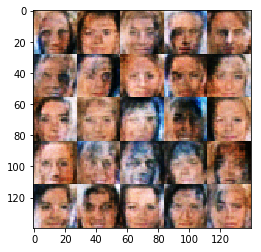

Epoch 1/1... Step 3010 Discriminator Loss: 1.3749... Generator Loss: 0.8790
Epoch 1/1... Step 3020 Discriminator Loss: 1.3842... Generator Loss: 0.9094
Epoch 1/1... Step 3030 Discriminator Loss: 1.3858... Generator Loss: 0.6040
Epoch 1/1... Step 3040 Discriminator Loss: 1.3852... Generator Loss: 0.7645
Epoch 1/1... Step 3050 Discriminator Loss: 1.3963... Generator Loss: 0.8321
Epoch 1/1... Step 3060 Discriminator Loss: 1.4856... Generator Loss: 0.6411
Epoch 1/1... Step 3070 Discriminator Loss: 1.3698... Generator Loss: 0.8816
Epoch 1/1... Step 3080 Discriminator Loss: 1.3838... Generator Loss: 0.9100
Epoch 1/1... Step 3090 Discriminator Loss: 1.4261... Generator Loss: 0.7547
Epoch 1/1... Step 3100 Discriminator Loss: 1.3476... Generator Loss: 0.7893


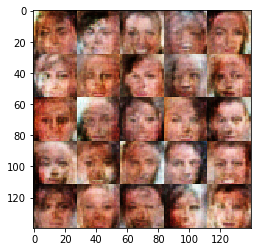

Epoch 1/1... Step 3110 Discriminator Loss: 1.5607... Generator Loss: 0.8041
Epoch 1/1... Step 3120 Discriminator Loss: 1.2643... Generator Loss: 0.9803
Epoch 1/1... Step 3130 Discriminator Loss: 11.6906... Generator Loss: 3.3804
Epoch 1/1... Step 3140 Discriminator Loss: 14.5576... Generator Loss: 2.0141
Epoch 1/1... Step 3150 Discriminator Loss: 2.3564... Generator Loss: 14.3737
Epoch 1/1... Step 3160 Discriminator Loss: 1.7818... Generator Loss: 21.2271


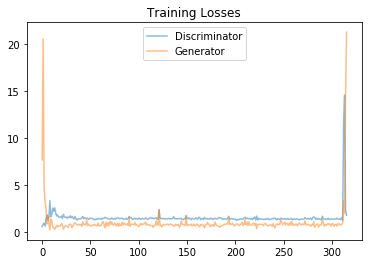

In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.